<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part8/P8_Ch04_CH08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nbformat==5.8.0
!pip install nbconvert==7.3.1

# 흑백 -> 컬러이미지 Colorization Task


  ![PFCN dataset](https://www.researchgate.net/profile/Dawei_Li49/publication/334417334/figure/fig4/AS:832930272276492@1575597460956/Sample-images-from-the-PFCN-dataset.jpg)

     위의 이미지는 다음과 같은 것을 보여줍니다.  
    - 800x600의 사람 portrait 이미지  
     - ?????.png  
    - 사람 영역에 대한 흑백 portrait 이미지
     - ?????_matte.png
    - pfcn_original
     - 원본 800x600 이미지들
    - pfcn_small
     - colab용 100x75 이미지들



- 데이터 출처:
 - [PFCN dataset](https://1drv.ms/u/s!ApwdOxIIFBH19Ts5EuFd9gVJrKTo)
 - [pfcn_small](https://drive.google.com/file/d/1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl/view?usp=sharing)


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

# 1. EDA

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


In [4]:
!ls -al /gdrive/MyDrive/딥러닝_정주행/P8_Ch02.인물사진에서배경없애기

total 161695
-rw------- 1 root root  23713432 Oct 23 10:41 lecture003.h5
-rw------- 1 root root   4572521 Oct 23 10:46 P8_Ch02_CH06,07.ipynb
-rw------- 1 root root 137288603 Oct 12 07:20 pfcn_small.npz


In [5]:
pfcn_small = np.load('/gdrive/MyDrive/딥러닝_정주행/P8_Ch02.인물사진에서배경없애기/pfcn_small.npz')


In [6]:
print(list(pfcn_small.keys()))

train_images = pfcn_small['train_images']
test_images = pfcn_small['test_images']

['train_images', 'test_images', 'train_mattes', 'test_mattes']


In [7]:
train_images[train_images !=0][:10]

array([0.23627451, 0.34803922, 0.64705882, 0.24509804, 0.35686275,
       0.65588235, 0.25490196, 0.36470588, 0.66470588, 0.2372549 ])

In [8]:
print(train_images.dtype)
print(len(train_images))

float64
1700


In [9]:
print(train_images.shape, test_images.shape)
print(len(train_images), len(test_images))


(1700, 100, 75, 3) (300, 100, 75, 3)
1700 300


In [10]:
train_images[train_images !=0]

array([0.23627451, 0.34803922, 0.64705882, ..., 0.05588235, 0.0245098 ,
       0.01470588])

In [11]:
train_images.dtype, test_images.dtype

(dtype('float64'), dtype('float64'))

In [12]:
print(train_images.min())
print(train_images.max())

print('----------------')
print(test_images.min())
print(test_images.max())

0.0
1.0
----------------
0.0
1.0


# 2. 전처리

- train_gray_images, test_gray_images 생성

In [13]:
from skimage import color

train_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in train_images])
test_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in test_images])


print(train_gray_images.shape, test_gray_images.shape)

(1700, 100, 75, 1) (300, 100, 75, 1)


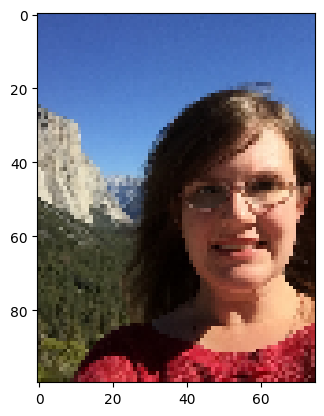

In [14]:
plt.imshow(train_images[0])

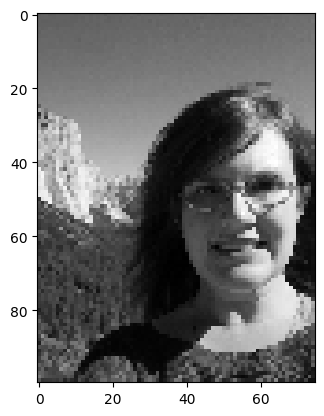

In [15]:
plt.imshow(train_gray_images[0], cmap ='gray')

# 3. Visualization

In [16]:
train_images[:5].shape, train_gray_images[:5].shape

((5, 100, 75, 3), (5, 100, 75, 1))

In [17]:
five = train_images[:5].transpose((1,0,2,3)).reshape((100,-1, 3))

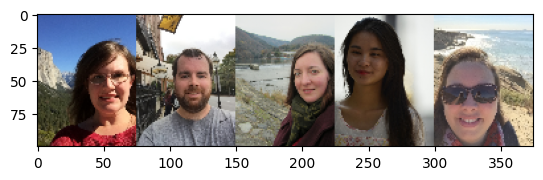

In [18]:
plt.imshow(five)

In [19]:
five_gray = train_gray_images[:5].transpose((1,0,2,3)).reshape((100,-1))

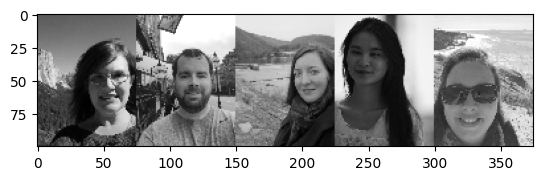

In [20]:
plt.imshow(five_gray, cmap ='gray')

# 4. 흑백 -> 컬러 모델링
- (100, 75, 1) -> (100, 75, 3)

In [21]:
from tensorflow import keras
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten
from keras.layers import Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

In [65]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def unet_color():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding = 'valid', output_padding= (0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding = 'valid', output_padding= (1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding = 'valid', output_padding= (0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding = 'valid', output_padding= (0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(3, 1, activation ='sigmoid')(c9)

    model = Model(inputs, outputs)

    return model


In [66]:
model = unet_color()

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100, 75, 1)]         0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 100, 75, 16)          160       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 100, 75, 16)          64        ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_36 (Activation)  (None, 100, 75, 16)          0         ['batch_normalization_36

In [67]:
model.compile(loss = 'mae', optimizer = 'adam', metrics =['accuracy'])

In [71]:
hist2 = model.fit(train_gray_images, train_images, validation_data =[test_gray_images, test_images], epochs =50, verbose =1)

Epoch 1/50
54/54 [==============================] - 5s 83ms/step - loss: 0.0528 - accuracy: 0.6639 - val_loss: 0.0560 - val_accuracy: 0.6235
Epoch 2/50
54/54 [==============================] - 4s 69ms/step - loss: 0.0524 - accuracy: 0.6663 - val_loss: 0.0549 - val_accuracy: 0.6793
Epoch 3/50
54/54 [==============================] - 4s 75ms/step - loss: 0.0517 - accuracy: 0.6716 - val_loss: 0.0498 - val_accuracy: 0.6684
Epoch 4/50
54/54 [==============================] - 4s 73ms/step - loss: 0.0522 - accuracy: 0.6770 - val_loss: 0.0508 - val_accuracy: 0.6560
Epoch 5/50
54/54 [==============================] - 4s 66ms/step - loss: 0.0508 - accuracy: 0.6726 - val_loss: 0.0498 - val_accuracy: 0.6537
Epoch 6/50
54/54 [==============================] - 4s 65ms/step - loss: 0.0501 - accuracy: 0.6850 - val_loss: 0.0495 - val_accuracy: 0.6794
Epoch 7/50
54/54 [==============================] - 4s 69ms/step - loss: 0.0494 - accuracy: 0.6856 - val_loss: 0.0487 - val_accuracy: 0.6750
Epoch 8/50
54

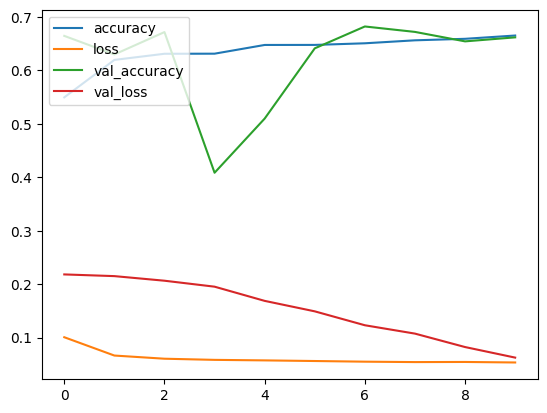

In [69]:
plt.plot(hist2.history['accuracy'], label = 'accuracy')
plt.plot(hist2.history['loss'], label = 'loss')
plt.plot(hist2.history['val_accuracy'], label = 'val_accuracy')
plt.plot(hist2.history['val_loss'], label = 'val_loss')

plt.legend(loc = 'upper left')
plt.show()

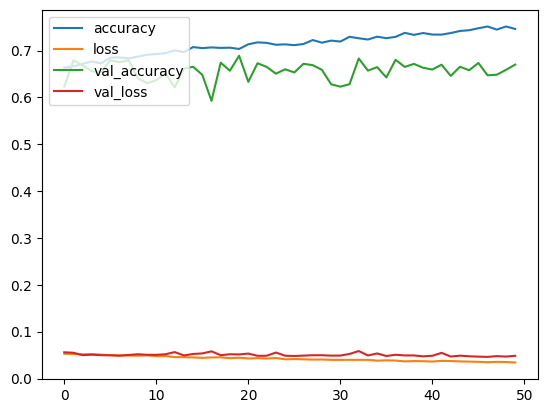

In [72]:
plt.plot(hist2.history['accuracy'], label = 'accuracy')
plt.plot(hist2.history['loss'], label = 'loss')
plt.plot(hist2.history['val_accuracy'], label = 'val_accuracy')
plt.plot(hist2.history['val_loss'], label = 'val_loss')

plt.legend(loc = 'upper left')
plt.show()

# 5. Colorization 모델 결과 확인

In [27]:
res = model.predict(test_gray_images[0:1])

1/1 [==============================] - 1s 974ms/step


In [28]:
print((test_gray_images[0:1]).shape)
print(res.shape)

(1, 100, 75, 1)
(1, 100, 75, 3)


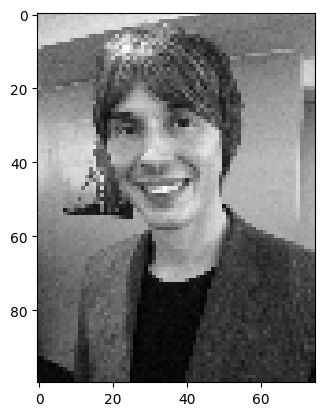

In [29]:
plt.imshow(test_gray_images[0], cmap ='gray')

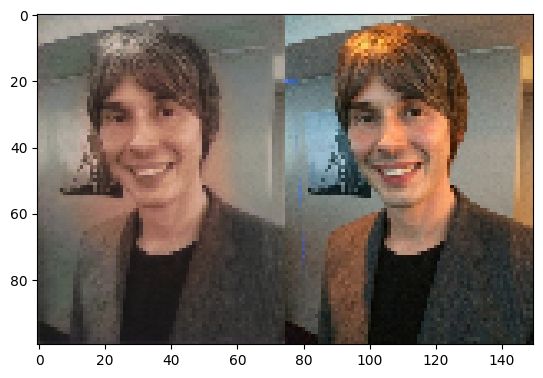

In [30]:
plt.imshow(np.concatenate([res[0], test_images[0]], axis = 1))

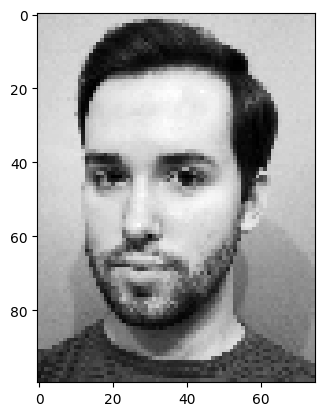

In [31]:
plt.imshow(test_gray_images[1], cmap = 'gray')

In [32]:
res = model.predict(test_gray_images[1:2])

1/1 [==============================] - 0s 36ms/step


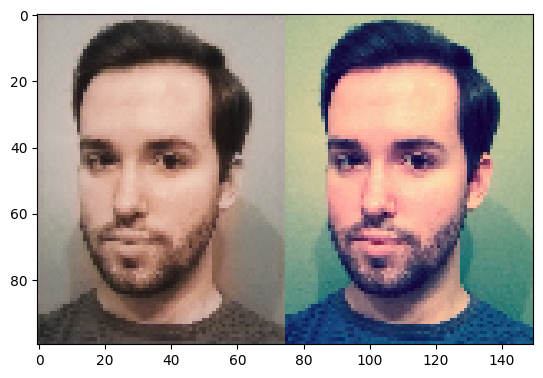

In [33]:
plt.imshow(np.concatenate([res[0], test_images[1]], axis = 1))


1/1 [==============================] - 0s 403ms/step


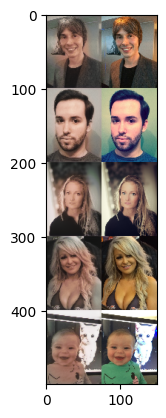

In [34]:
# 10 Epochs
five = model.predict(test_gray_images[:5])
plt.imshow(np.concatenate([five, test_images[:5]], axis =2).reshape((-1, 150, 3)))

1/1 [==============================] - 0s 35ms/step


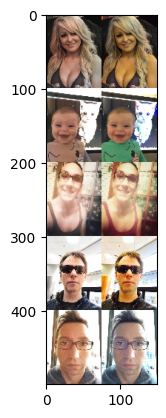

In [142]:
# 50 Epochs -> 10epoch 보다 더 세피아톤
five_model1 = model.predict(test_gray_images[3:8])
plt.imshow(np.concatenate([five_model1, test_images[3:8]], axis =2).reshape((-1, 150, 3)))

- 전반적으로 살색은 잘 예측해 보이지만 배경에 대한 색들이 톤다운되어있다.
- 모델이 오차를 최소화 하는 과정에서 전반적인 배경에 대한 접근이 세피아 톤으로 맞춘것 같다.

# 6. 모델링 2 : Lab color 로 변경
- 모든 printer에 대해 보장된 색상으로 변경
- RGB는 색상을 3채널로 표현, Lab color는 Light (빛) 채널 1개와 Color 채널 2개 (a, b)로 표현한다.

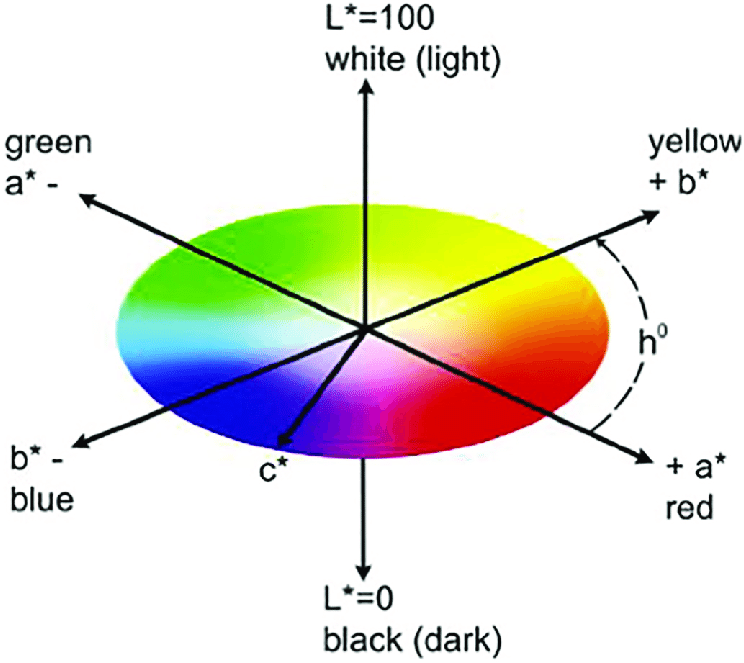

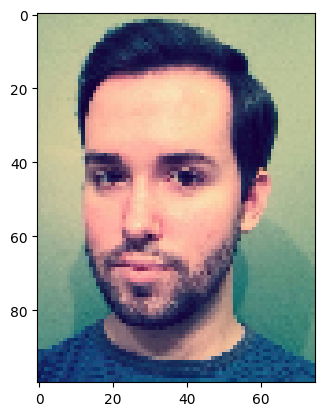

In [36]:
# rgb -> lab

plt.imshow(test_images[1])

In [37]:
color.rgb2lab(test_images[1]).shape

(100, 75, 3)

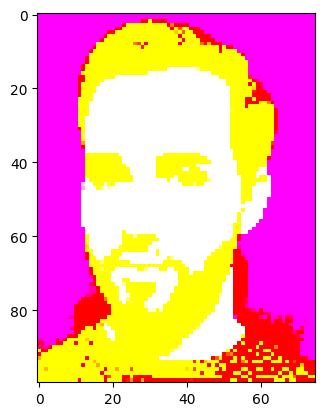

In [39]:
plt.imshow(color.rgb2lab(test_images[1]))

In [40]:
train_lab_images = np.array([color.rgb2lab(img) for img in train_images])
test_lab_images = np.array([color.rgb2lab(img) for img in test_images])

In [44]:
# channel별 최대 최소 확인
print(train_lab_images[..., 0].min(), train_lab_images[..., 0].max())
print(train_lab_images[..., 1].min(), train_lab_images[..., 1].max())
print(train_lab_images[..., 2].min(), train_lab_images[..., 2].max())

0.0 100.0
-78.53736435567544 86.20773183914271
-91.97308466277427 93.80664030542576


- Lab color를 Normalization

In [49]:
# lab color는 채널별로 [0~100, -128~+128, -128~+128]을 갖고있다. -> 0-1 normalization

# 1 channel 0~100 에 +0 -> 0~100 -> 100으로 나누기 -> 0~1
# 2 channel -128 ~ +128 에 + 128 -> 0 ~ 255 -> 255로 나누기 -> 0~1
# 3 channel -128 ~ +128 에 + 128 -> 0 ~ 255 -> 255로 나누기 -> 0~1

a = train_lab_images + [0, 128, 128]
print(a[...,0].min(), a[...,0].max())
print(a[...,1].min(), a[...,1].max())
print(a[...,2].min(), a[...,2].max())

b = a / [100, 255, 255]
print(b[...,0].min(), b[...,0].max())
print(b[...,1].min(), b[...,1].max())
print(b[...,2].min(), b[...,2].max())

0.0 100.0
49.462635644324564 214.2077318391427
36.02691533722573 221.80664030542576
0.0 1.0
0.19397112017382181 0.8400303209378145
0.141282020930297 0.8698299619820618


In [50]:
train_lab_images = (train_lab_images + [0, 128, 128]) / [100, 255, 255]
test_lab_images = (test_lab_images + [0, 128, 128]) / [100, 255, 255]

In [51]:
print(train_lab_images[..., 0].min(), train_lab_images[..., 0].max())
print(train_lab_images[..., 1].min(), train_lab_images[..., 1].max())
print(train_lab_images[..., 2].min(), train_lab_images[..., 2].max())

0.0 1.0
0.19397112017382181 0.8400303209378145
0.141282020930297 0.8698299619820618


In [52]:
train_lab_images[1][...,0].shape

(100, 75)

- L channel 이 밝기를 담당하기 때문에

- 기존모델 grayscale -> r g b 예측
- 새로운 모델 L -> a, b예측

- model1(grayscale x) -> rgb
- model2(L x) -> L x + a + b -> rgb

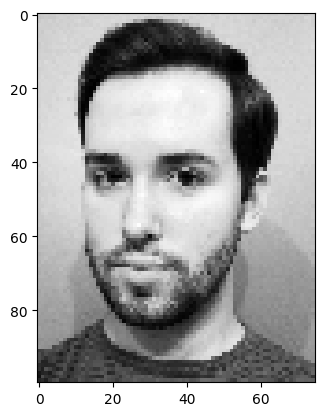

In [58]:
plt.imshow(test_lab_images[1][...,0], cmap = 'gray')

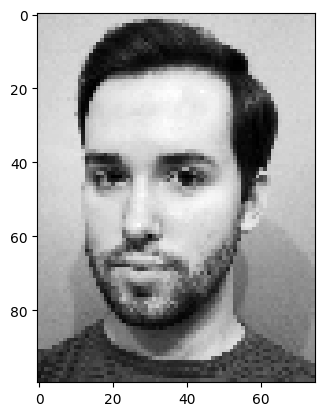

In [57]:
plt.imshow(test_gray_images[1], cmap = 'gray')
plt.show()

In [59]:
# 흑백 -> lab 컬러 모델링
# (100, 75, 1) -> (100, 75, 2)

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def unet_lab():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding = 'valid', output_padding= (0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding = 'valid', output_padding= (1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding = 'valid', output_padding= (0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding = 'valid', output_padding= (0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(2, 1, activation ='sigmoid')(c9)

    model = Model(inputs, outputs)

    return model


In [60]:
model2 = unet_lab()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 75, 1)]         0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 100, 75, 16)          160       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 100, 75, 16)          64        ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 100, 75, 16)          0         ['batch_normalization_18

In [61]:
model2.compile(loss = 'mae', optimizer='adam', metrics =['accuracy'])

In [63]:
hist = model2.fit(train_lab_images[...,0:1], train_lab_images[...,1:3], validation_data = (test_lab_images[...,0:1], test_lab_images[...,1:3]) , epochs = 50, verbose=1)

Epoch 1/50
54/54 [==============================] - 4s 80ms/step - loss: 0.0320 - accuracy: 0.6137 - val_loss: 0.0317 - val_accuracy: 0.6229
Epoch 2/50
54/54 [==============================] - 3s 63ms/step - loss: 0.0324 - accuracy: 0.6123 - val_loss: 0.0326 - val_accuracy: 0.6139
Epoch 3/50
54/54 [==============================] - 3s 63ms/step - loss: 0.0319 - accuracy: 0.6149 - val_loss: 0.0319 - val_accuracy: 0.6100
Epoch 4/50
54/54 [==============================] - 4s 66ms/step - loss: 0.0317 - accuracy: 0.6170 - val_loss: 0.0313 - val_accuracy: 0.6286
Epoch 5/50
54/54 [==============================] - 4s 67ms/step - loss: 0.0316 - accuracy: 0.6198 - val_loss: 0.0309 - val_accuracy: 0.6080
Epoch 6/50
54/54 [==============================] - 3s 64ms/step - loss: 0.0316 - accuracy: 0.6206 - val_loss: 0.0309 - val_accuracy: 0.6289
Epoch 7/50
54/54 [==============================] - 3s 64ms/step - loss: 0.0315 - accuracy: 0.6227 - val_loss: 0.0307 - val_accuracy: 0.6230
Epoch 8/50
54

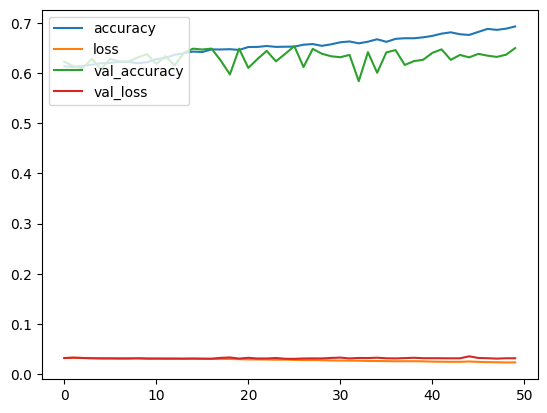

In [64]:
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.plot(hist.history['val_loss'], label = 'val_loss')

plt.legend(loc = 'upper left')
plt.show()

# 7. lab 모델 결과확인

In [128]:
light = test_lab_images[2][...,0:1]

In [123]:
light.shape

(100, 75, 1)

In [124]:
res = model2.predict(np.expand_dims(light, axis = 0))

1/1 [==============================] - 0s 27ms/step


In [125]:
res.shape

(1, 100, 75, 2)

In [129]:
def l2rgb(l):
    pred_ab = model2.predict(np.expand_dims(l, axis = 0))
    pred_img = np.zeros((100, 75, 3))

    pred_img[:,:,0] = l.reshape((100, 75))
    pred_img[:,:,1:] = pred_ab[0]

    # denormalization
    pred_lab = (pred_img * [100, 255, 255]) - [0, 128, 128]
    rgb_img = color.lab2rgb(pred_lab)

    return rgb_img

1/1 [==============================] - 0s 135ms/step


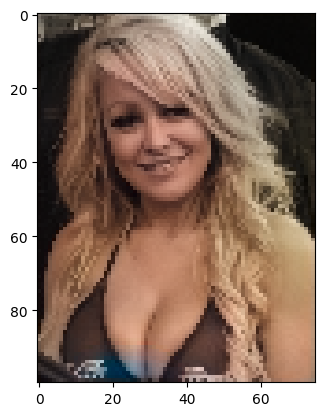

In [131]:
plt.imshow(l2rgb(test_lab_images[3][...,0:1]))

1/1 [==============================] - 0s 32ms/step


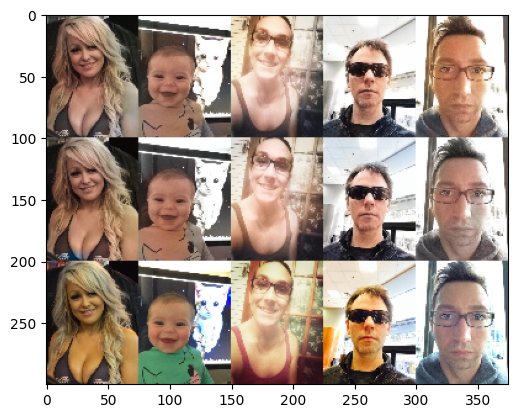

In [145]:
five = np.array([l2rgb(img) for img in test_lab_images[3:8][...,0:1]])
plt.imshow(np.concatenate([ model.predict(test_gray_images[3:8]),five, test_images[3:8]], axis = 1).transpose((1,0,2,3)).reshape((300, -1, 3)))

- 세피아 톤이 개선되고 조금더 컬러감 있는 사진으로 예측되었다.

# 8. 모델 저징 및 로드, 다운

In [147]:
model2.save('/content/drive/MyDrive/딥러닝_정주행/P8_Ch04.흑백사진을칼라사진으로변경하기/model2.h5')

In [149]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/딥러닝_정주행/P8_Ch04.흑백사진을칼라사진으로변경하기/model2.h5')

In [151]:
loss, acc = new_model.evaluate(test_lab_images[...,0:1], test_lab_images[...,1:3], verbose =1)

10/10 [==============================] - 0s 33ms/step - loss: 0.0314 - accuracy: 0.6501
